In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

In [2]:
import dataset_builder as db
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13],
}

In [3]:
import tensorflow as tf 
import keras 
import keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from collections import Counter
from keras import regularizers
from keras.models import Sequential, Model, load_model, model_from_json 
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Reshape, Concatenate,  Dropout 
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

/Users/malekzadeh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["rotationRate","userAcceleration"]
mode = "mag"
cga = True # Add gravity to acceleration or not
print("[INFO] -- Selected sensor data types: "+str(sdt)+" -- Mode: "+str(mode)+" -- Grav+Acc: "+str(cga))    

act_labels = ACT_LABELS [0:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = db.set_data_types(sdt)
dataset = db.creat_time_series(dt_list, act_labels, trial_codes, mode=mode, labeled=True, combine_grav_acc = cga)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    

### Subject Setting ###
test_ids = [4,9,11,21]
print("[INFO] -- Test IDs: "+str(test_ids))
test_ts = dataset.loc[(dataset['id'].isin(test_ids))]
train_ts = dataset.loc[~(dataset['id'].isin(test_ids))]

print("[INFO] -- Shape of Train Time-Series :"+str(train_ts.shape))
print("[INFO] -- Shape of Test Time-Series :"+str(test_ts.shape))

[INFO] -- Selected sensor data types: ['rotationRate', 'userAcceleration'] -- Mode: mag -- Grav+Acc: True
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(767660, 9)
[INFO] -- Test IDs: [4, 9, 11, 21]
[INFO] -- Shape of Train Time-Series :(646207, 9)
[INFO] -- Shape of Test Time-Series :(121453, 9)


In [5]:
val_trail = [11,12,13,14,15,16]
val_ts = train_ts.loc[(train_ts['trial'].isin(val_trail))]
train_ts = train_ts.loc[~(train_ts['trial'].isin(val_trail))]
print("[INFO] -- Shape of Train Time-Series :"+str(train_ts.shape))
print("[INFO] -- Shape of Test Time-Series :"+str(val_ts.shape))

[INFO] -- Shape of Train Time-Series :(523129, 9)
[INFO] -- Shape of Test Time-Series :(123078, 9)


In [6]:
## This Variable Defines the Size of Sliding Window
## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor) 
w = 128 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
## Here We Choose Step Size for Building Diffrent Snapshots from Time-Series Data
## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
s = 128
train_data, act_train, id_train, train_mean, train_std = db.ts_to_secs(train_ts.copy(),
                                                                   w,
                                                                   s,
                                                                   standardize = True)

s = 128
val_data, act_val, id_val, val_mean, val_std = db.ts_to_secs(val_ts.copy(),
                                                              w,
                                                              s,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std)


s = 128
test_data, act_test, id_test, test_mean, test_std = db.ts_to_secs(test_ts.copy(),
                                                              w,
                                                              s,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std)

# print("[INFO] -- Shape of Training Sections: "+str(train_data.shape))
# print("[INFO] -- Shape of Training Sections: "+str(val_data.shape))
print("[INFO] -- Shape of Test Sections:  "+str(test_data.shape))

[INFO] -- Training Data has been standardized: the mean is = [2.17728825 1.19431016] ; and the std is = [1.43229632 0.70168121]
[INFO] -- Test Data has been standardized
[INFO] -- Test Data has been standardized
[INFO] -- Shape of Test Sections:  (906, 2, 128)


In [7]:
id_train_labels = to_categorical(id_train)
id_val_labels = to_categorical(id_val)
id_test_labels = to_categorical(id_test)
id_test_labels = np.append(id_test_labels, np.zeros((len(id_test_labels),2)), axis =1)

act_train_labels = to_categorical(act_train)
act_val_labels = to_categorical(act_val)
act_test_labels = to_categorical(act_test)
    
## Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
train_data = np.expand_dims(train_data,axis=3)
print("[INFO] -- Shape of Training Sections:", train_data.shape)
val_data = np.expand_dims(val_data,axis=3)
print("[INFO] -- Validation Sections:"+str(val_data.shape))
test_data = np.expand_dims(test_data,axis=3)
print("[INFO] -- Shape of Training Sections:", test_data.shape)

[INFO] -- Shape of Training Sections: (3950, 2, 128, 1)
[INFO] -- Validation Sections:(883, 2, 128, 1)
[INFO] -- Shape of Training Sections: (906, 2, 128, 1)


In [8]:
X = train_data.copy()
Yact = act_train_labels
vX = val_data.copy()
vYact = act_val_labels
tX = test_data.copy()
tYact = act_test_labels

In [9]:
lm_file = "msda_anon_model"
json_file = open(lm_file+".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
anon_model = model_from_json(loaded_model_json)
anon_model.load_weights(lm_file+"_weights.h5")
print("Loaded model from disk")

atX = anon_model.predict(test_data, verbose=1)[0]

Loaded model from disk
906/906 [==============================] - 7s 8ms/step


28


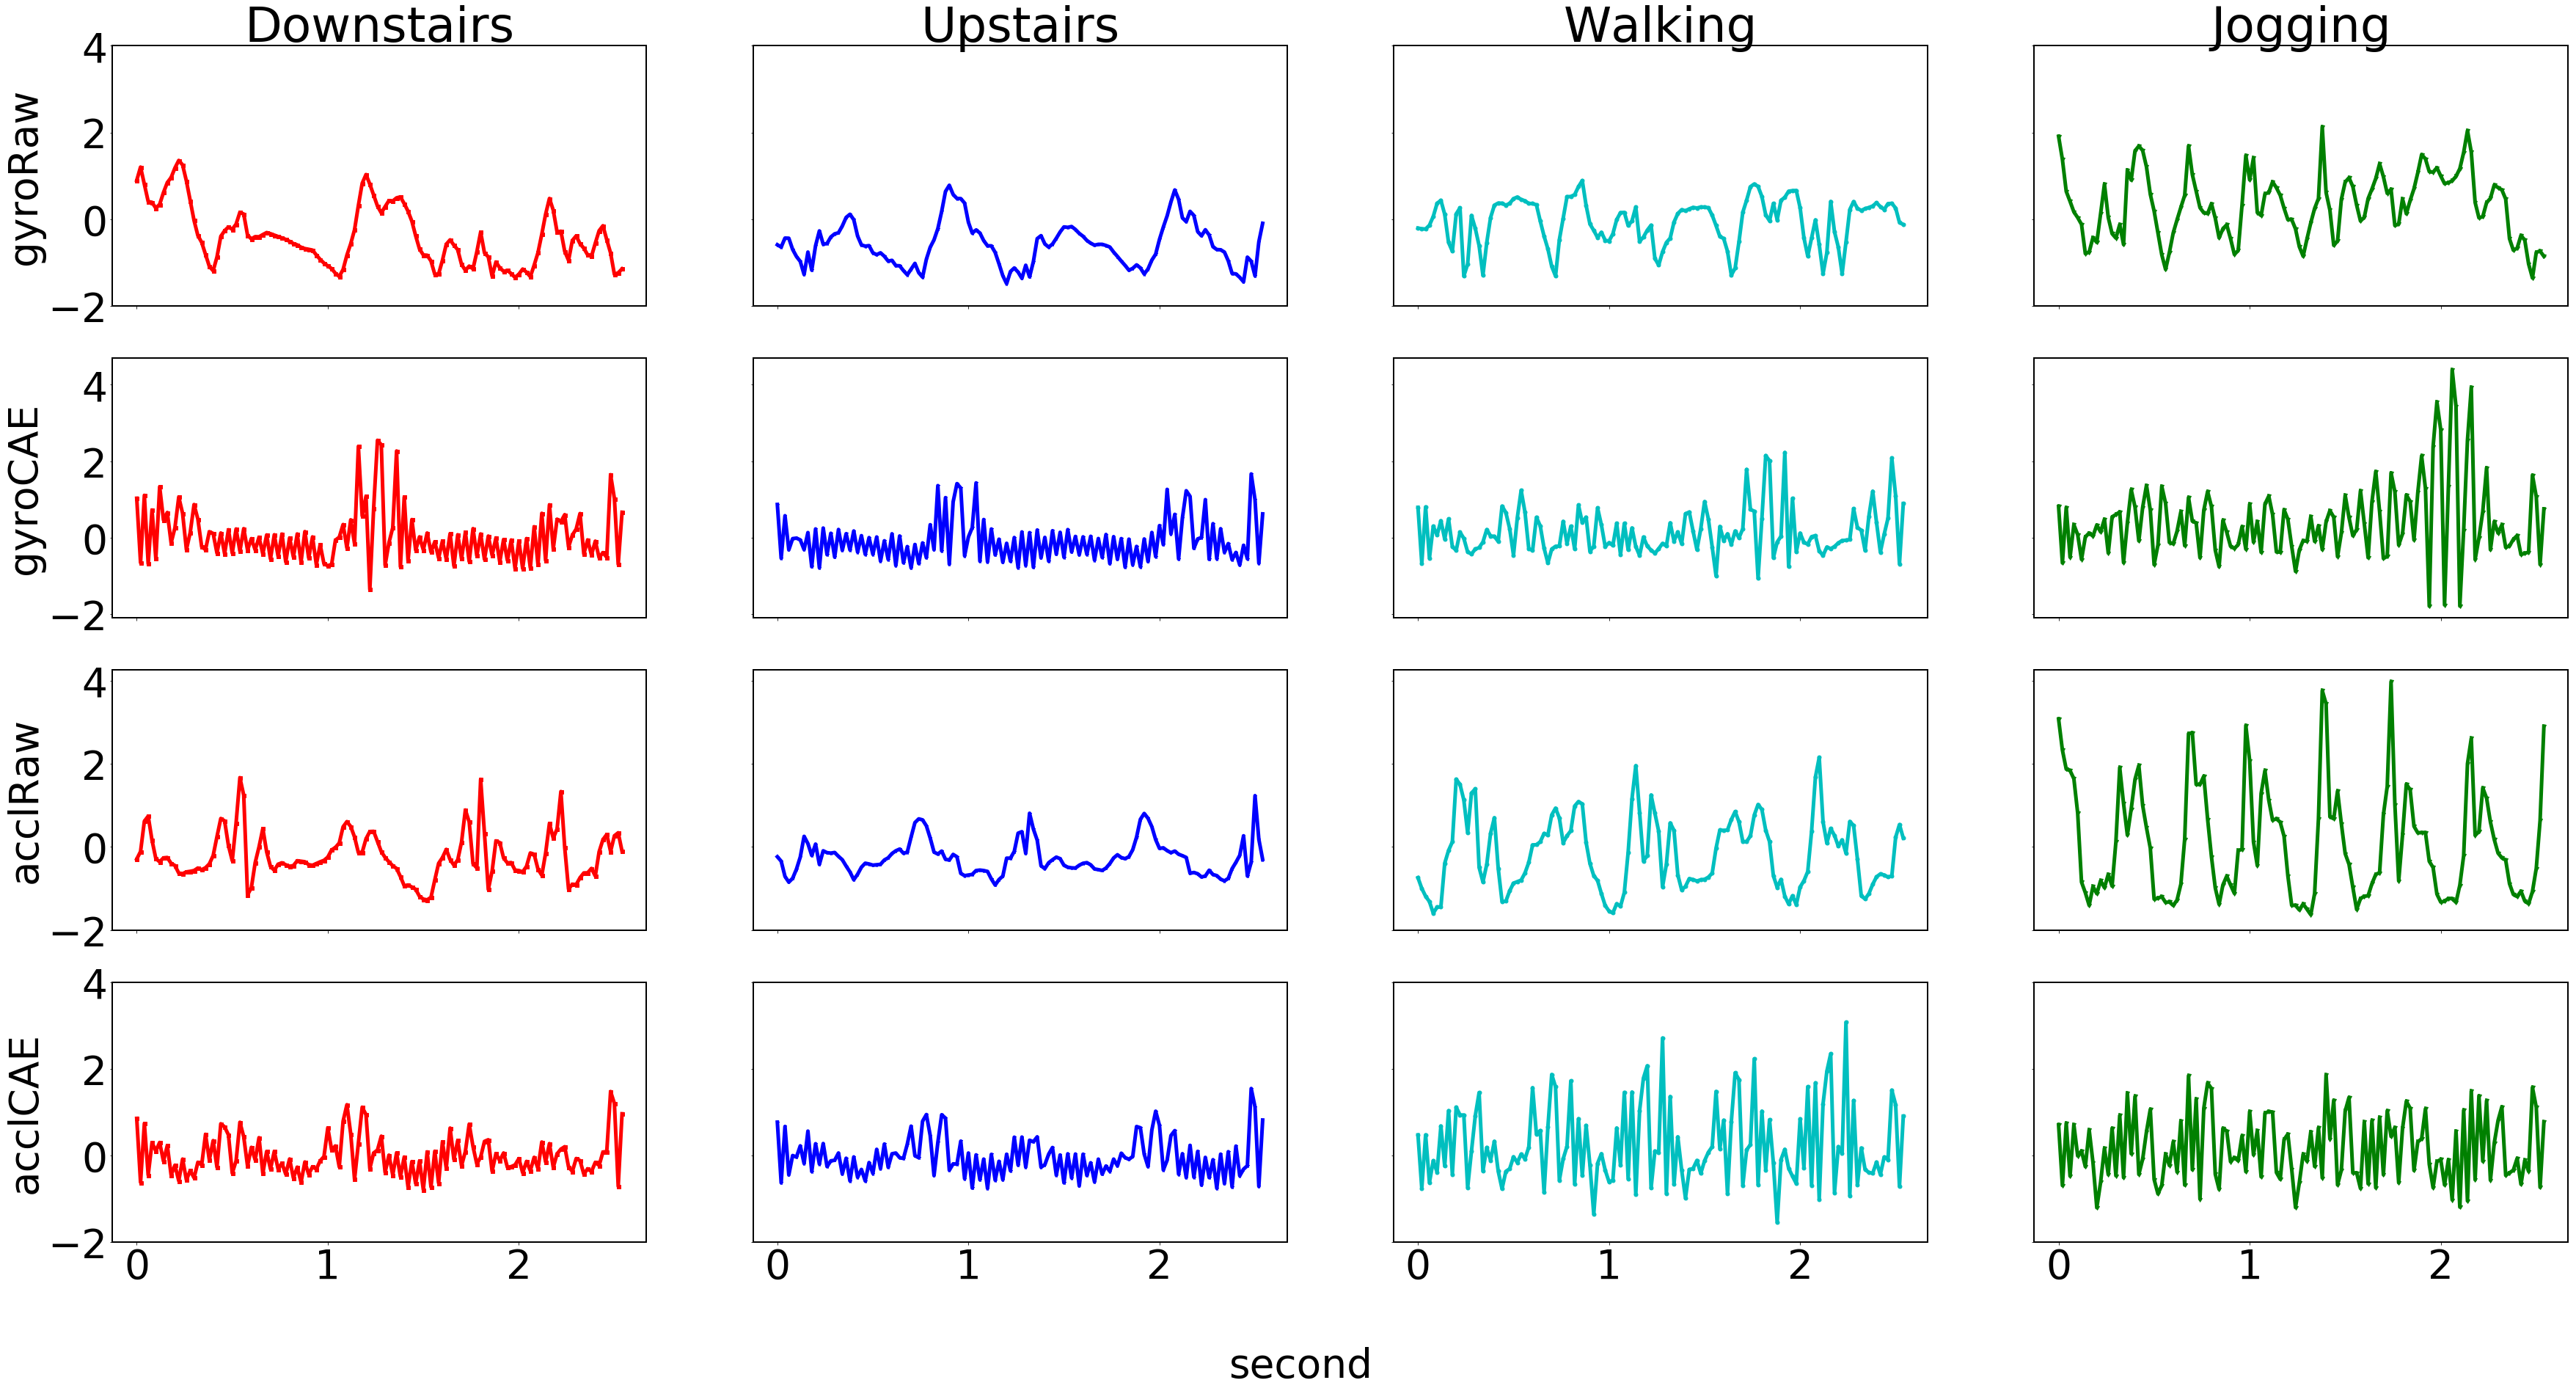

In [10]:
import scipy
plt.rcParams['figure.figsize'] = (60,30)
plt.rcParams['font.size'] = 55
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

act_lbl = ["Downstairs", "Upstairs", "Walking", "Jogging"]
lbl = ["Downstairs", "Upstairs", "Walking", "Jogging"]
dt = ["gyroRaw","gyroCAE","acclRaw","acclCAE"]
clr = ["rs-","b*-","co-","gv-"]  

rnd_smpl= np.random.randint(100)
pts = 128

fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
for k in range(4):
    raw_gyro = tX[act_test_labels[:,k]==1.0][rnd_smpl,0,:,0]   
    cae_gyro = atX[act_test_labels[:,k]==1.0][rnd_smpl,0,:,0]
    raw_accl = tX[act_test_labels[:,k]==1.0][rnd_smpl,1,:,0]   
    cae_accl = atX[act_test_labels[:,k]==1.0][rnd_smpl,1,:,0]
    ax[0,k].plot(np.arange(0.,128./50.,1./50), raw_gyro, clr[k], linewidth=5, markersize=5)
    ax[1,k].plot(np.arange(0.,128./50.,1./50), cae_gyro, clr[k], linewidth=5, markersize=5)
    ax[2,k].plot(np.arange(0.,128./50.,1./50), raw_accl, clr[k], linewidth=5, markersize=5)
    ax[3,k].plot(np.arange(0.,128./50.,1./50), cae_accl, clr[k], linewidth=5, markersize=5)    
    ax[0,k].set_title(lbl[k])
    ax[k,0].set_ylabel(dt[k])
    
    
plt.setp(ax, yticks=np.arange(-2, 6, 2))
fig.text(0.5, 0.04, 'second', ha='center')
#fig.text(0.04, 0.5, 'magnitude value', va='center', rotation='vertical', fontsize=26)
# ax[0].legend(loc="upper center", fontsize=26)
print(rnd_smpl)

28


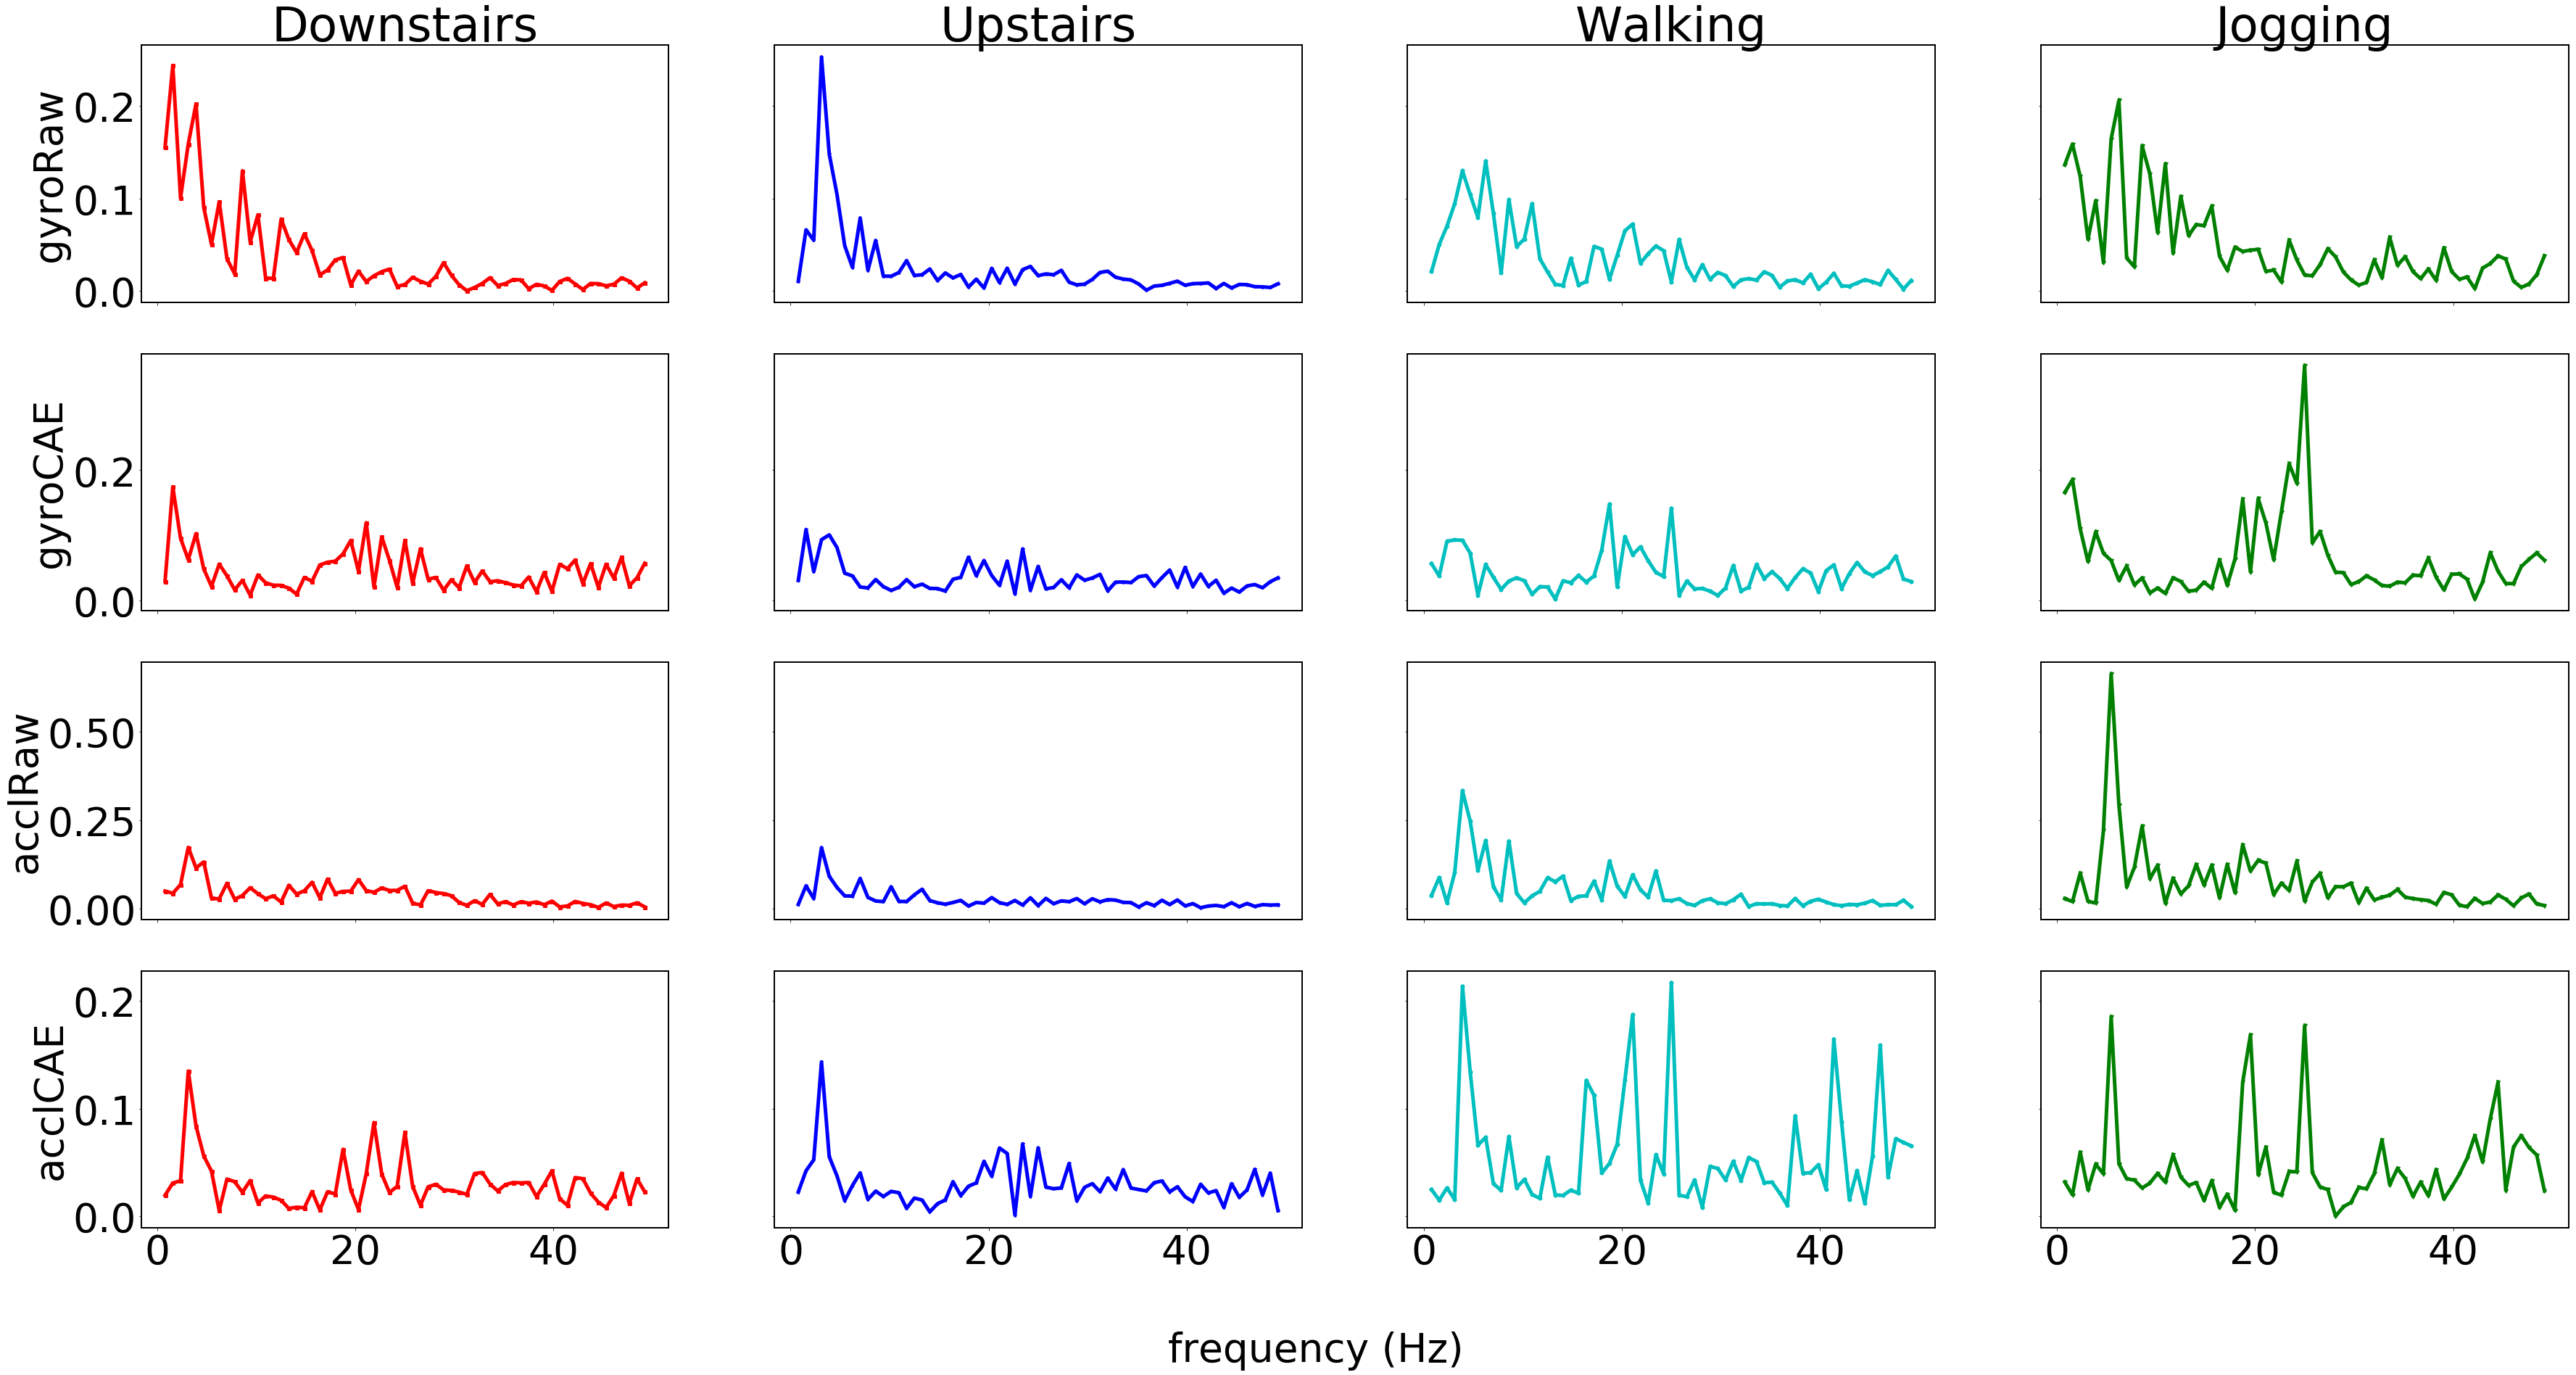

In [11]:
from scipy import fft, arange
Fs = 100.0;  # sampling rate
k = arange(pts)
T = pts/Fs
frq = k/T # two sides frequency range
frq = frq[np.arange(1,pts//2)] # one side frequency range


fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
for k in range(4):
    raw_gyro = abs((fft(tX[act_test_labels[:,k]==1.0][rnd_smpl,0,:,0])/pts)[range(pts//2)])[1:]
    cae_gyro = abs((fft(atX[act_test_labels[:,k]==1.0][rnd_smpl,0,:,0])/pts)[range(pts//2)])[1:]
    raw_accl = abs((fft(tX[act_test_labels[:,k]==1.0][rnd_smpl,1,:,0])/pts)[range(pts//2)])[1:]
    cae_accl = abs((fft(atX[act_test_labels[:,k]==1.0][rnd_smpl,1,:,0])/pts)[range(pts//2)])[1:]
    ax[0,k].plot(frq, raw_gyro, clr[k], linewidth=5, markersize=5)
    ax[1,k].plot(frq, cae_gyro, clr[k], linewidth=5, markersize=5)
    ax[2,k].plot(frq, raw_accl, clr[k], linewidth=5, markersize=5)
    ax[3,k].plot(frq, cae_accl, clr[k], linewidth=5, markersize=5)    
    ax[0,k].set_title(lbl[k])
    ax[k,0].set_ylabel(dt[k])
    
    
#plt.setp(ax, xticks=range(0, 128, 25), yticks=np.arange(-2, 6, 2))
fig.text(0.5, 0.04, 'frequency (Hz)', ha='center')
#fig.text(0.04, 0.5, 'magnitude value', va='center', rotation='vertical', fontsize=26)
# ax[0].legend(loc="upper center", fontsize=26)
print(rnd_smpl)

Text(0.05,0.5,'frequency (Hz)')

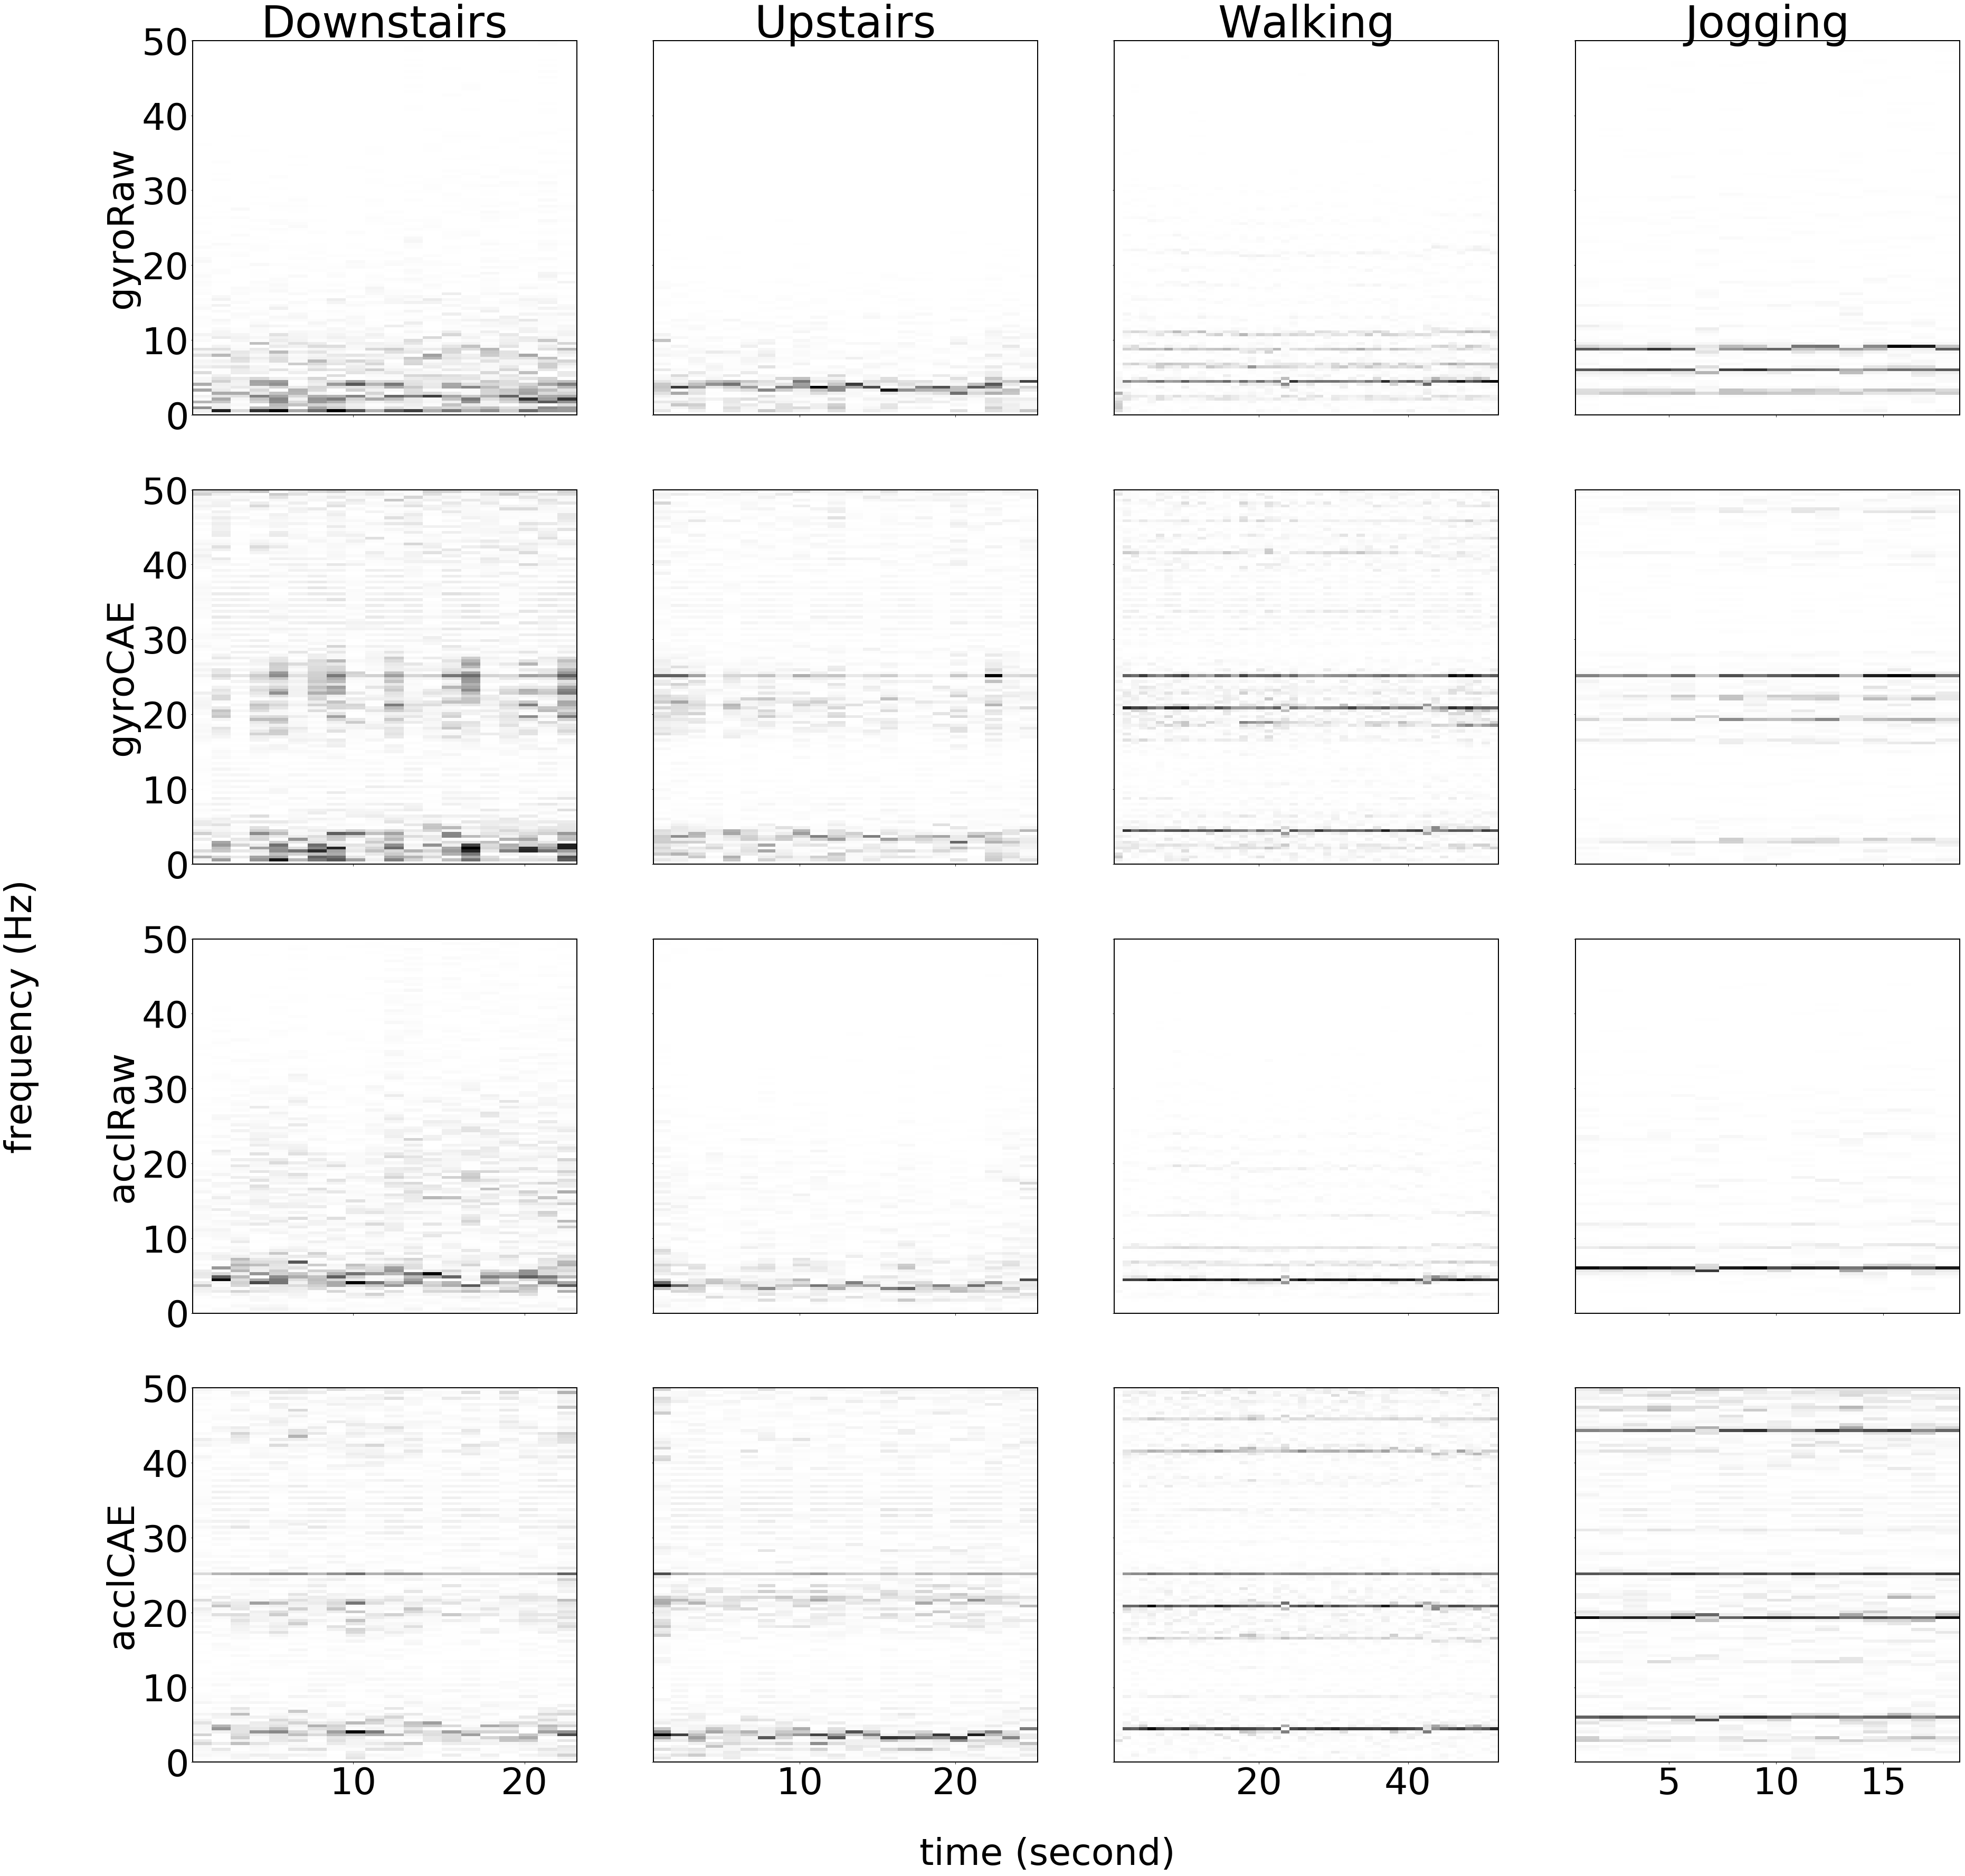

In [12]:
from scipy import signal
plt.rcParams['figure.figsize'] = (60,60)
plt.rcParams['font.size'] = 70
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')

tid = 4
fs = 100
for tact in range(4):
    indx = np.logical_and(id_test_labels[:,tid]==1.0, act_test_labels[:,tact]==1.0)
    raw_gyro = np.zeros(0)
    cae_gyro = np.zeros(0)
    raw_accl = np.zeros(0)
    cae_accl = np.zeros(0)
    for j in range(len(tX[indx])):
        raw_gyro = np.append(raw_gyro, tX[indx][j,0,:,0])
        cae_gyro = np.append(cae_gyro, atX[indx][j,0,:,0])
        raw_accl = np.append(raw_accl, tX[indx][j,1,:,0])
        cae_accl = np.append(cae_accl, atX[indx][j,1,:,0])
    
    f, t, Sxx = signal.spectrogram(raw_gyro, fs)
    ax[0,tact].pcolormesh(t/2, f, Sxx, cmap='binary', snap=True)
    f, t, Sxx = signal.spectrogram(cae_gyro, fs)
    ax[1,tact].pcolormesh(t/2, f, Sxx, cmap='binary', snap=True)
    f, t, Sxx = signal.spectrogram(raw_accl, fs,)
    ax[2,tact].pcolormesh(t/2, f, Sxx, cmap='binary', snap=True)
    f, t, Sxx = signal.spectrogram(cae_accl, fs)
    ax[3,tact].pcolormesh(t/2, f, Sxx, cmap='binary', snap=True)
    ax[0,tact].set_title(lbl[tact])
    ax[tact,0].set_ylabel(dt[tact])

fig.text(0.5, 0.08, 'time (second)', ha='center')
fig.text(0.05, 0.5, 'frequency (Hz)', ha='center', rotation = 'vertical')
